In [53]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import pandas as pd
import photutils

from scipy import stats
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from photutils.detection import DAOStarFinder
from photutils.morphology import data_properties
from astropy.stats import mad_std

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

from tensorflow.config import list_logical_devices, list_physical_devices, set_visible_devices
from tensorflow.config.experimental import set_memory_growth



In [2]:
#Setup notebook so Tensorflow works in a friendly way in a shared multi GPU env

def setup_tensorflow(seed=None):
    try:
        import nvsmi

        gpu_mem_free = np.array([gpu.mem_free for gpu in nvsmi.get_gpus()])
        if len(gpu_mem_free) > 0 and (gpu_mem_free > 0).any():
            idx = np.argmax(gpu_mem_free)
            gpu = list_physical_devices("GPU")[idx]
            set_memory_growth(gpu, True)
            set_visible_devices(gpu, "GPU")
            gpus = list_logical_devices("GPU")
            print(f"Using GPU: {gpus}")
        else:
            raise Exception
    except:
        print(f"Tensorflow using CPU")
    tf.random.set_seed(seed)
    

In [3]:
setup_tensorflow()

Using GPU: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-05-10 12:32:28.429330: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-10 12:32:28.932243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9650 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


In [4]:

#load the image arrays 

#Blends/Components 2 is where the blends have been made AFTER the galaxies have had noise and shift added to them not before

blends = np.load("blends_small.npy")
components = np.load("components_small.npy")


In [5]:
#Constant factor normalisation 

#Lets just divide them all by the maximum value found 

norm_max = np.max([ np.max(blends), np.max(components) ])

blends = blends / norm_max 

components = components / norm_max

In [6]:
"""

#Min Max Norm

norm_max = np.max([ np.max(blends), np.max(components) ])
norm_min = np.min([ np.min(blends), np.min(components) ])


blends = (blends - norm_min) / (norm_max - norm_min) 

components = (components - norm_min) / (norm_max - norm_min)

"""

'\n\n#Min Max Norm\n\nnorm_max = np.max([ np.max(blends), np.max(components) ])\nnorm_min = np.min([ np.min(blends), np.min(components) ])\n\n\nblends = (blends - norm_min) / (norm_max - norm_min) \n\ncomponents = (components - norm_min) / (norm_max - norm_min)\n\n'

In [7]:
blends.shape, components.shape

((10000, 64, 64), (2, 10000, 64, 64))

In [8]:
np.mean(blends), np.mean(components)

(0.07820520256284358, 0.03910260128142177)

In [9]:
#This should be close to 0 or orders of magnitude smaller than the mean of the blends / components 
print(np.sum(blends - (components[0] + components[1])))

3.763534395789877e-15


In [10]:
#Split into training and test set 

#Going to split training and test 80% and 20% respectively 

train_ngals = int(blends.shape[0] * 0.8)
test_ngals = int(blends.shape[0] * 0.2)

train_blends = blends[:train_ngals]
test_blends = blends[train_ngals:]

a, b, c, d, test_components = np.split(components, 5, axis = 1)

train_components = np.concatenate((a, b, c, d), axis = 1)




In [11]:
np.amax(train_blends), np.amin(train_blends), np.amax(test_blends), np.amin(test_blends)

(1.0, 3.919078115069311e-12, 0.9661154213823644, 9.73682532642654e-10)

In [12]:
np.amax(test_components), np.amin(test_components), np.amax(test_blends), np.amin(test_blends)

(0.5881960230212645,
 8.865050453391251e-23,
 0.9661154213823644,
 9.73682532642654e-10)

In [13]:
height,width=64,64

train_blends = train_blends.reshape(train_ngals, height, width, 1).astype('float32')
train_components = train_components.reshape(2, train_ngals, height, width, 1).astype('float32')

test_blends = test_blends.reshape(test_ngals, height, width, 1).astype('float32')
test_components = test_components.reshape(2, test_ngals, height, width, 1).astype('float32')


In [14]:
batch_size = 32
latent_dimensions = 32

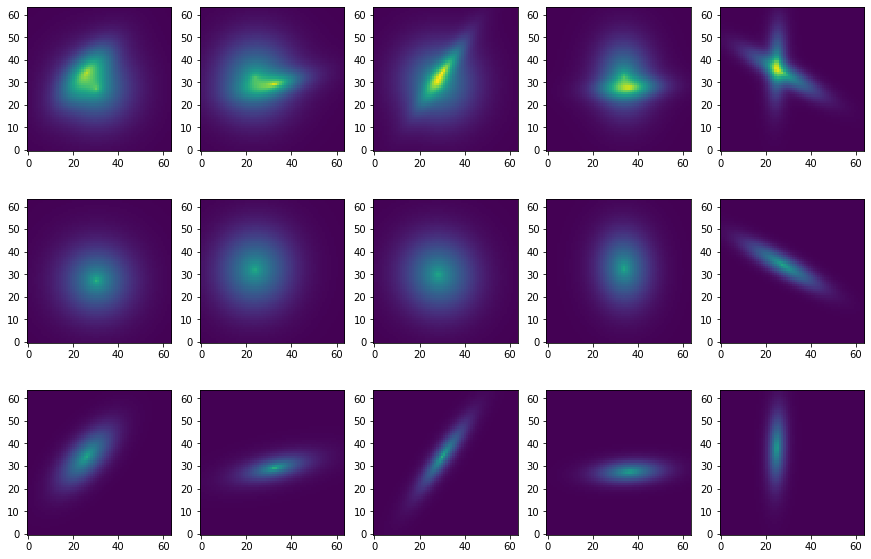

In [15]:
fig, ax = plt.subplots(2 + 1, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(train_blends[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
    ax[1, i].imshow(train_components[0, i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
    ax[2, i].imshow(train_components[1, i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)

In [16]:
#Will optimise encoder / decoder later
def encoder(x):
    x=Conv2D(32,3,activation='relu', strides = 2, padding='same')(x)
    x=Conv2D(64,3,activation='relu', strides = 2, padding='same')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [17]:
def decoder(x):
    x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu', strides = 2 ,padding='same')(x)
    x=Conv2DTranspose(32,3,activation='relu', strides = 2 ,padding='same')(x)
    return x

In [18]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [19]:
# encoder
input_blend=Input(shape=(height, width,1))

encoded=encoder(input_blend)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

In [20]:
# decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

embed2=Dense(np.prod(shape),activation='relu')(input_embed)
embed2=Reshape(shape)(embed2)
decoded2=decoder(embed2)
output2=Conv2DTranspose(1,3,padding='same')(decoded2)

In [21]:
encode=Model(input_blend,z)
encode.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 64)     0           ['conv2d_1[0][0]']               
                                                                                              

In [22]:
input_component1 = Input(shape=(height, width, 1))
input_component2 = Input(shape=(height, width, 1))

decode=Model([input_embed, input_component1, input_component2], [output1, output2])
decode.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 4096)         135168      ['input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 4096)         135168      ['input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 8, 8, 64)     0           ['dense_2[0][0]']                
                                                                                            

In [23]:
encoding = encode(input_blend)
re1, re2 = decode([encoding, input_component1, input_component2])

vae = Model([input_blend, input_component1, input_component2], [re1, re2])

In [24]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 32)           281024      ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                            

In [25]:
mse_lossA = mse(input_component1, re1) + mse(input_component2, re2)
mse_lossA = tf.reduce_mean(mse_lossA / 2, axis=(1, 2))
mse_lossB = mse(input_component1, re2) + mse(input_component2, re1)
mse_lossB = tf.reduce_mean(mse_lossB / 2, axis=(1, 2))
mse_loss = tf.reduce_mean(tf.minimum(mse_lossA, mse_lossB)) * height * width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss, 'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*0.1
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')


train_together = [train_blends, train_components[0], train_components[1]]
test_together = [test_blends, test_components[0], test_components[1]]

vae.compile(optimizer=Adam())

In [26]:
history=vae.fit(train_together, verbose = 1, epochs = 20, batch_size = batch_size, validation_split = 0.2)

Epoch 1/20


2022-05-10 12:32:35.139635: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


200/200 [==============================] - 8s 16ms/step - loss: 6.9162 - mse_loss: 6.7455 - kl_loss: 0.1707 - val_loss: 4.6433 - val_mse_loss: 4.4383 - val_kl_loss: 0.2050
Epoch 2/20
200/200 [==============================] - 3s 14ms/step - loss: 4.3399 - mse_loss: 4.1238 - kl_loss: 0.2160 - val_loss: 3.9886 - val_mse_loss: 3.7731 - val_kl_loss: 0.2155
Epoch 3/20
200/200 [==============================] - 3s 14ms/step - loss: 3.8090 - mse_loss: 3.5867 - kl_loss: 0.2223 - val_loss: 3.5395 - val_mse_loss: 3.3170 - val_kl_loss: 0.2225
Epoch 4/20
200/200 [==============================] - 3s 14ms/step - loss: 3.3013 - mse_loss: 3.0706 - kl_loss: 0.2308 - val_loss: 3.1559 - val_mse_loss: 2.9156 - val_kl_loss: 0.2402
Epoch 5/20
200/200 [==============================] - 3s 14ms/step - loss: 2.9056 - mse_loss: 2.6671 - kl_loss: 0.2386 - val_loss: 2.8364 - val_mse_loss: 2.5950 - val_kl_loss: 0.2414
Epoch 6/20
200/200 [==============================] - 3s 14ms/step - loss: 2.4820 - mse_loss: 2.

In [27]:
def histplot(history):
    plt.rcParams["figure.figsize"] = (10,7)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label = 'Training loss')
    plt.plot(epochs, val_loss, label = 'Validation loss')
    plt.axhline( y = min(val_loss), color = 'black', linestyle = 'dotted', label = f'Minimum Validation Loss: {min(val_loss):.4f}')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

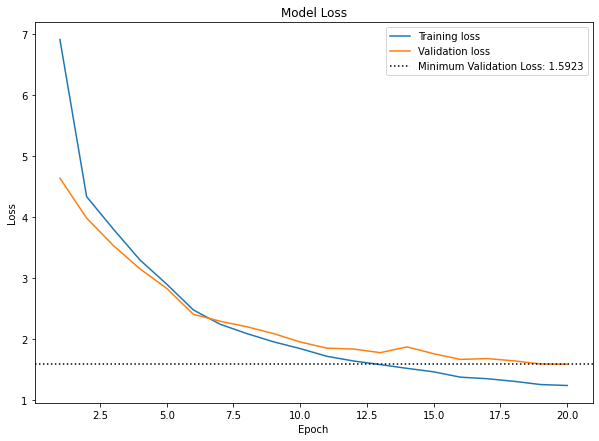

In [28]:
histplot(history)

In [29]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    comp1 = inputs[1][idx]
    comp2 = inputs[2][idx]
    z = encode.predict(input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    fig, ax = plt.subplots(7, n, figsize=((3)*n,15))
    for i in range(n):
        ax[0, i].imshow(input_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[0, i].set_title('Input Blend')
        ax[1, i].imshow(comp1[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[1, i].set_title('Input Component 1')
        ax[2, i].imshow(comp2[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[2, i].set_title('Input Component 2')
        ax[3, i].imshow(output_img1[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[3, i].set_title('Reconstruction Component 1')
        ax[3, i].set_xlabel(f'MSE: {mean_squared_error(comp1[i], output_img1[i]):.2f}, SSIM: {ssim(comp1[i], output_img1[i], channel_axis = 2):.2f}')
        ax[4, i].imshow(output_img2[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[4, i].set_title('Reconstruction Component 2')
        ax[5, i].imshow((output_img1[i] + output_img2[i]) , origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[5, i].set_title('Reconstruction Blend')
        ax[4, i].set_xlabel(f'MSE: {mean_squared_error(comp2[i], output_img2[i]):.2f}, SSIM: {ssim(comp2[i], output_img2[i], channel_axis = 2):.2f}')
        ax[6, i].imshow(abs(input_img[i] -(output_img1[i] + output_img2[i])) , origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[6, i].set_title('Blend Difference')
        plt.tight_layout()
    return idx

[ 674 1699 1282 1315 1210]


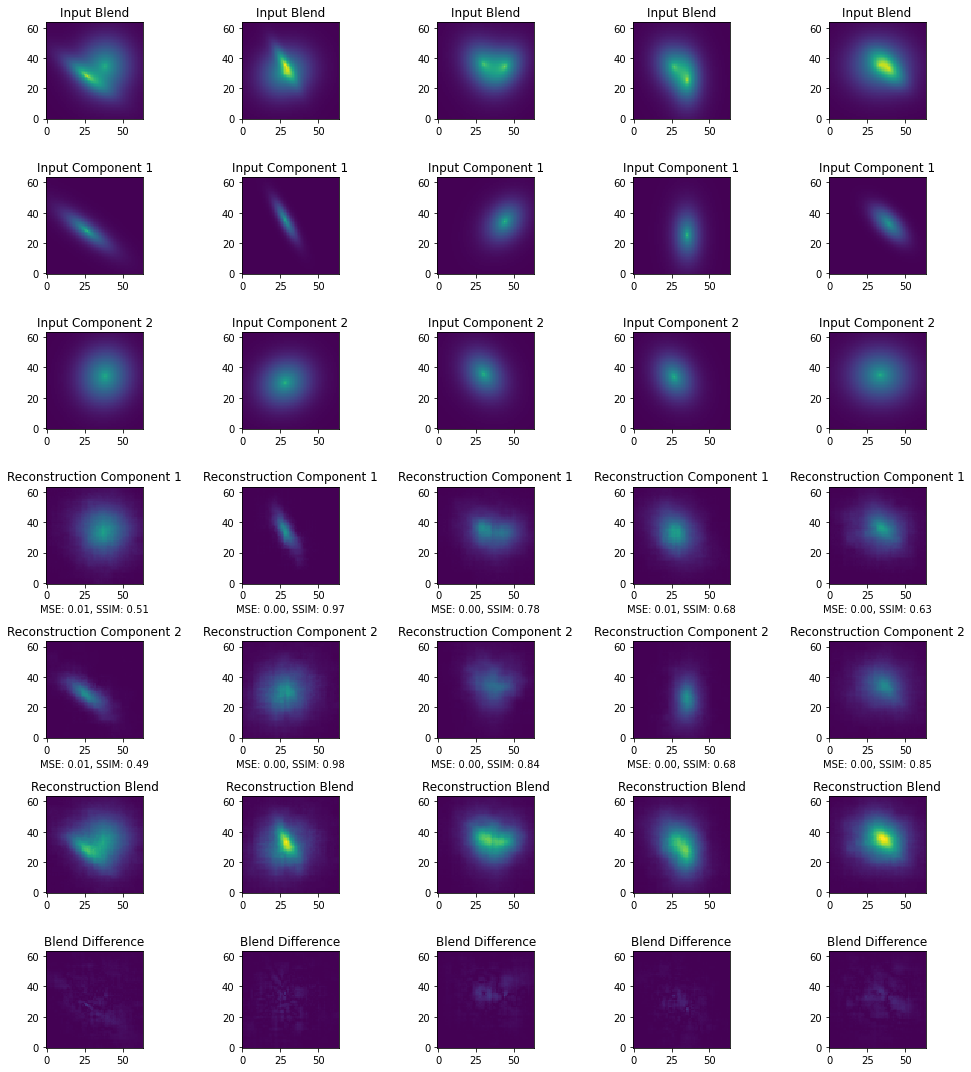

In [30]:
n=5
chosen=summary_plot(n,test_together,decode)

In [31]:
def calc_ssim(inputs,decode):
    ssim_comp1 = np.zeros(test_ngals)
    ssim_comp2 = np.zeros(test_ngals)
    ssim_blends = np.zeros(test_ngals)
    input_img = inputs[0]
    comp1 = inputs[1]
    comp2 = inputs[2]
    z = encode.predict(input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    for i in range(test_ngals):
        ssim_comp1[i] = ssim(comp1[i], output_img1[i], channel_axis = 2)
        ssim_comp2[i] = ssim(comp2[i], output_img2[i], channel_axis = 2)
        ssim_blends[i] = ssim(input_img[i], (output_img1[i] + output_img2[i]), channel_axis = 2)
    mean_ssim_comp1 = np.mean(ssim_comp1)
    median_ssim_comp1 = np.median(ssim_comp1)
    
    mean_ssim_comp2 = np.mean(ssim_comp2)
    median_ssim_comp2 = np.median(ssim_comp2)
    
    mean_ssim_blends = np.mean(ssim_blends)
    median_ssim_blends = np.median(ssim_blends)
    
    ssim_values = np.array([mean_ssim_comp1, median_ssim_comp1, mean_ssim_comp2, median_ssim_comp2, mean_ssim_blends, median_ssim_blends])
    
    return ssim_values 
        
        
        

    
    

In [32]:
ssim_values = calc_ssim(test_together, decode)


In [33]:
mean_ssim_comp1 = ssim_values[0]
median_ssim_comp1 = ssim_values[1]
mean_ssim_comp2 = ssim_values[2]
median_ssim_comp2 = ssim_values[3]
mean_ssim_blends = ssim_values[4]
median_ssim_blends = ssim_values[5]

In [34]:
print(f' Mean SSIMs: Component 1: {mean_ssim_comp1:.4f}, Component 2: {mean_ssim_comp2:.4f}, Blends: {mean_ssim_blends:.4f}')

print(f' Median SSIMs: Component 1: {median_ssim_comp1:.4f}, Component 2: {median_ssim_comp2:.4f}, Blends: {median_ssim_blends:.4f}')


 Mean SSIMs: Component 1: 0.8093, Component 2: 0.8117, Blends: 0.9689
 Median SSIMs: Component 1: 0.8777, Component 2: 0.8779, Blends: 0.9739


In [35]:
from numpy.random import uniform, lognormal, normal

def add_noise(img, scale=0.01):
    return img + normal(scale=scale, size=img.shape)

In [36]:
#This function calculates the properties of the input and output images. The ellipticity and flux are stored in arrays 

def calc_properties(inputs,decode):
    
    empty_array = np.zeros(test_ngals)
    
    flux_in_comp1 = np.zeros(test_ngals)
    flux_in_comp2 = np.zeros(test_ngals)
    flux_in_blends = np.zeros(test_ngals)
    
    flux_out_comp1 = np.zeros(test_ngals)
    flux_out_comp2 = np.zeros(test_ngals)
    flux_out_blends = np.zeros(test_ngals)
    
    
    elip_in_comp1 = np.zeros(test_ngals)
    elip_in_comp2 = np.zeros(test_ngals)
    
    elip_out_comp1 = np.zeros(test_ngals)
    elip_out_comp2 = np.zeros(test_ngals)
    
    #input_img = inputs[0]
    comp1 = inputs[1]
    comp1 = comp1.reshape(test_ngals, height, width)
    comp2 = inputs[2]
    comp2 = comp2.reshape(test_ngals, height,width)
    input_img = comp1 + comp2
    input_img = input_img.reshape(test_ngals, height, width)
    z = encode.predict(input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    
    output_img1 = output_img1.reshape(test_ngals, height, width)
    output_img2 = output_img2.reshape(test_ngals, height, width)
    
    output_blend = output_img1 + output_img2
    
    output_blend = add_noise(output_blend)
    
    for i in range(test_ngals):
        
        in_comp1_cat = photutils.morphology.data_properties(comp1[i], mask = None, background = 0)
        elip_in_comp1[i] = in_comp1_cat.ellipticity
        flux_in_comp1[i] = in_comp1_cat.segment_flux
        
        in_comp2_cat = photutils.morphology.data_properties(comp2[i], mask = None, background = 0)
  
        elip_in_comp2[i] = in_comp2_cat.ellipticity
        flux_in_comp2[i] = in_comp2_cat.segment_flux
        
        in_blends_cat = photutils.morphology.data_properties(input_img[i], mask = None, background = 0)
        flux_in_blends[i] = in_blends_cat.segment_flux

            
        out_comp1_cat = photutils.morphology.data_properties(output_img1[i], mask = None, background = 0)
        elip_out_comp1[i] = out_comp1_cat.ellipticity
        flux_out_comp1[i] = out_comp1_cat.segment_flux
        
        out_comp2_cat = photutils.morphology.data_properties(output_img2[i], mask = None, background = 0)
        elip_out_comp2[i] = out_comp2_cat.ellipticity
        flux_out_comp2[i] = out_comp2_cat.segment_flux
        
        out_blends_cat = photutils.morphology.data_properties(output_blend[i], mask = None, background = 0)
        flux_out_blends[i] = out_blends_cat.segment_flux
        
        parameters = [elip_in_comp1, elip_out_comp1, flux_in_comp1, flux_out_comp1, elip_in_comp2, elip_out_comp2, flux_in_comp2, flux_out_comp2, flux_in_blends, flux_out_blends]   
    return parameters


        

In [37]:
parameters = calc_properties(test_together, decode)
print(parameters)

[array([0.3536669 , 0.63834618, 0.61997215, ..., 0.52823005, 0.14369593,
       0.07068295]), array([0.09507707, 0.03944412, 0.34844445, ..., 0.35597689, 0.15577463,
       0.39098635]), array([122.4878391 ,  75.5764205 ,  99.64436132, ...,  90.96574237,
       146.92640082, 231.69531117]), array([159.60789123, 268.71125498,  84.66891264, ..., 124.08374485,
       158.89877965, 108.24737691]), array([0.14092075, 0.04005255, 0.44350451, ..., 0.28190573, 0.20310312,
       0.57227594]), array([0.1886116 , 0.37941978, 0.33426717, ..., 0.25938138, 0.04184215,
       0.00994793]), array([173.68531523, 286.40679816, 168.10574896, ..., 223.37577579,
       202.4530506 , 106.5099827 ]), array([131.32263517,  82.69221001, 167.34329802, ..., 185.24985534,
       184.82848363, 220.92443449]), array([296.17315412, 361.98321879, 267.75011046, ..., 314.34151804,
       349.37945207, 338.20529418]), array([291.66783692, 351.10056509, 252.2413627 , ..., 307.97098528,
       343.21791506, 329.52627653]

In [38]:

ellip_in_comp1 = parameters[0]
ellip_out_comp1 = parameters[1]
flux_in_comp1 = parameters[2]
flux_out_comp1 = parameters[3]
ellip_in_comp2 = parameters[4]
ellip_out_comp2 = parameters[5]
flux_in_comp2 = parameters[6]
flux_out_comp2 = parameters[7]
flux_in_blends = parameters[8]
flux_out_blends = parameters[9]





In [39]:
print(np.max(ellip_in_comp1) , np.min(ellip_in_comp1))

0.7880802489622873 0.0006842014392217655


In [40]:
#Calculate the standard deviations 
def calc_std(parameters):
    num_of_params = len(parameters)
    standard_dev_of_params = np.zeros(num_of_params)
    for i in range(0,num_of_params):
        standard_dev_of_params[i] = np.std(parameters[i])
    return standard_dev_of_params



In [41]:
std_of_params = calc_std(parameters)


In [42]:
print(f'Std dev of Ellip: Comp1 [In] {std_of_params[0]:.4f}, Comp1 [Out] {std_of_params[1]:.4f}, Comp2 [In] {std_of_params[4]:.4f}, Comp2 [Out] {std_of_params[5]:.4f} ')

Std dev of Ellip: Comp1 [In] 0.2259, Comp1 [Out] 0.1627, Comp2 [In] 0.2244, Comp2 [Out] 0.1309 


In [43]:
 print(f'Std dev of Flux: Comp1 [In] {std_of_params[2]:.4f}, Comp1 [Out] {std_of_params[3]:.4f}, Comp2 [In] {std_of_params[6]:.4f}, Comp2 [Out] {std_of_params[7]:.4f}, Blend [In] {std_of_params[8]:.4f}, Blend [Out] {std_of_params[9]:.4f} ')

Std dev of Flux: Comp1 [In] 68.0981, Comp1 [Out] 63.7160, Comp2 [In] 68.7499, Comp2 [Out] 60.8303, Blend [In] 97.0817, Blend [Out] 94.8178 


3.0
[-0.03868560180306716, 0.8274500522045762]


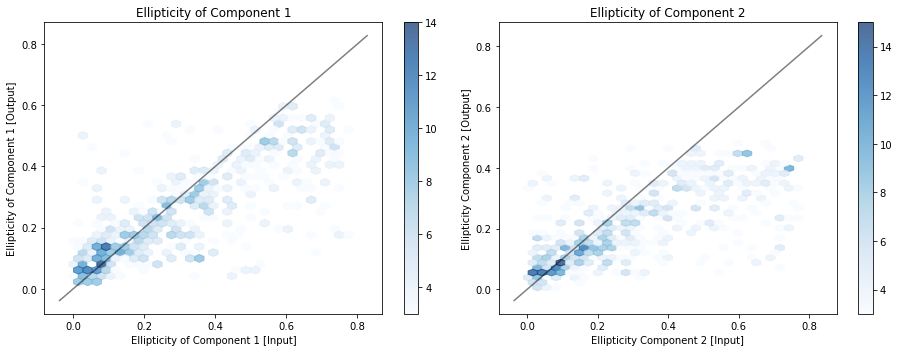

In [44]:
fig, axes = plt.subplots(1, 2, figsize = (13,5))

#Lets make minimum amount of number of points in a cell to display scale with number of test samples

n_mincnt = np.floor(test_blends.shape[0] / 10000) + 3
print(n_mincnt)

axes[0].set_title("Ellipticity of Component 1")
hex1 = axes[0].hexbin(ellip_in_comp1, ellip_out_comp1, gridsize=30, cmap='Blues', mincnt= n_mincnt, alpha=0.7)
axes[0].set_xlabel("Ellipticity of Component 1 [Input]")
axes[0].set_ylabel("Ellipticity of Component 1 [Output]")
fig.colorbar(hex1, ax=axes[0])

lims = [
    np.min([axes[0].get_xlim(), axes[0].get_ylim()]),  # min of both axes
    np.max([axes[0].get_xlim(), axes[0].get_ylim()]),  # max of both axes
]

print(lims)


# now plot both limits against eachother
axes[0].plot(lims, lims, 'k-', alpha=0.5, zorder=1)

axes[1].set_title("Ellipticity of Component 2")
hex2 = axes[1].hexbin(ellip_in_comp2, ellip_out_comp2, gridsize=30, cmap='Blues', mincnt= n_mincnt, alpha=0.7)
axes[1].set_xlabel("Ellipticity Component 2 [Input]")
axes[1].set_ylabel("Ellipticity Component 2 [Output]")
fig.colorbar(hex2, ax=axes[1])

ellip_lims = [
    np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
    np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
axes[1].plot(ellip_lims, ellip_lims, 'k-', alpha=0.5, zorder=1)


fig.tight_layout()

plt.show()

In [45]:
#I want to add in errors

#First need to split the data up

#Going to start with ellipticities 

np.max(ellip_in_comp1)
np.min(ellip_in_comp1)

n_of_splits = 10
splits = np.linspace( np.min(ellip_in_comp1) ,  np.max(ellip_in_comp1), n_of_splits)
print(splits)


split_boolean = (splits[0] <= ellip_in_comp1) & ( ellip_in_comp1 <= splits[1])

#Now need to use
print(ellip_in_comp1)

print(split_boolean)

part1 = (ellip_in_comp1[(splits[0] <= ellip_in_comp1) & ( ellip_in_comp1 <= splits[1])])
part1b = (ellip_out_comp1[(splits[0] <= ellip_in_comp1) & ( ellip_in_comp1 <= splits[1])])
error_1 = part1 - part1b

print(part1)
print(part1b)

print(error_1)

print(len(part1))
print(len(part1b))


#for i in range(len(ellip_in_comp1)-1):
    



[6.84201439e-04 8.81726512e-02 1.75661101e-01 2.63149551e-01
 3.50638000e-01 4.38126450e-01 5.25614900e-01 6.13103350e-01
 7.00591799e-01 7.88080249e-01]
[0.3536669  0.63834618 0.61997215 ... 0.52823005 0.14369593 0.07068295]
[False False False ... False False  True]
[0.02162166 0.02187726 0.02659591 0.07426244 0.01505033 0.02594346
 0.06309803 0.0763294  0.07250933 0.06639031 0.00533728 0.04534204
 0.03455969 0.01843576 0.07161134 0.04096712 0.04461639 0.03894516
 0.0681616  0.0197346  0.01194256 0.00891861 0.01491077 0.07419583
 0.06644785 0.0026244  0.02746596 0.07950871 0.0705722  0.06573059
 0.04958653 0.027559   0.0459263  0.07374337 0.02277839 0.04182001
 0.07110612 0.03348874 0.0749812  0.03813896 0.00608192 0.08196626
 0.01817575 0.05505592 0.04803448 0.06353374 0.07536392 0.05865762
 0.00784389 0.0398066  0.07846082 0.04726954 0.0305173  0.02342877
 0.03370756 0.04221072 0.08689392 0.02730077 0.01446745 0.03980426
 0.03249951 0.07688187 0.07796073 0.00877849 0.02708336 0.0816

In [51]:
#I want to do this using a loop 

total_errors = []

#Ellipticity comp1
for i in range(n_of_splits-1):
    part1 = (ellip_in_comp1[(splits[i] <= ellip_in_comp1) & ( ellip_in_comp1 <= splits[i+1])])
    part1b = (ellip_out_comp1[(splits[i] <= ellip_in_comp1) & ( ellip_in_comp1 <= splits[i+1])])
    error_1 = part1 - part1b
    #print(error_1)
    #Then we need to store error 1 
    total_errors.append(error_1)


print(total_errors)
    
#total_error = [part1, part2, part3, part4, part5, part6, part7, part8, part9]

[array([-3.57782629e-02, -4.33771590e-02, -8.18963955e-02, -4.95604252e-02,
       -5.50942228e-02, -8.33186472e-03, -4.58378040e-01, -3.89391702e-01,
       -9.21479898e-03,  5.23039741e-03, -1.43691335e-01,  1.38954257e-02,
       -2.78735014e-01, -2.33426267e-01, -9.22264719e-02, -3.75439740e-02,
       -2.59007617e-01, -2.49371507e-01, -7.62388444e-02, -2.82169139e-02,
       -5.40862659e-02, -8.35094182e-02, -3.79942523e-01, -9.43967570e-02,
        3.38445997e-02, -4.97148602e-01, -3.26525954e-01,  4.79033265e-02,
        3.92233842e-02, -2.25570438e-01, -1.09491926e-01, -7.68668816e-02,
       -1.05842473e-01, -4.98221203e-02, -1.76124766e-02, -1.39600762e-01,
       -2.09797052e-01, -1.07968929e-01,  7.14390009e-02, -8.91520372e-02,
       -1.71213814e-01, -5.99419931e-02, -4.74598815e-02,  1.51565268e-03,
       -9.97665618e-02, -1.17627512e-01, -3.01939304e-01, -2.63201337e-01,
       -1.30888248e-01, -3.75481991e-02, -7.57273278e-02, -4.58711902e-02,
       -4.76148911e-01, 

{'whiskers': [<matplotlib.lines.Line2D at 0x7f182c671520>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1854278ee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f182c5840a0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f182c7d5520>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f182c7d57f0>,
 'means': []}

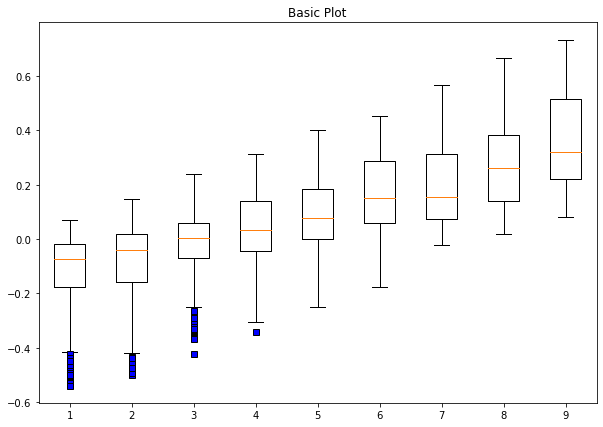

In [49]:
#Plotting
green_diamond = dict(markerfacecolor='b', marker='s')
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(total_errors, flierprops = green_diamond)

[5 9 8 ... 7 2 1]
[array([0.05739993, 0.06525442, 0.1084923 , 0.12382286, 0.07014455,
       0.03427532, 0.52147607, 0.4657211 , 0.08172413, 0.06115991,
       0.14902861, 0.03144661, 0.31329471, 0.25186203, 0.16383781,
       0.07851109, 0.30362401, 0.28831667, 0.14440044, 0.04795152,
       0.06602882, 0.09242802, 0.39485329, 0.16859259, 0.03260325,
       0.499773  , 0.35399191, 0.03134881, 0.29130102, 0.15907846,
       0.10442588, 0.15176878, 0.1235655 , 0.04039087, 0.18142077,
       0.28090317, 0.14145767, 0.0035422 , 0.127291  , 0.17729574,
       0.06563563, 0.05354027, 0.14780104, 0.18116125, 0.37730322,
       0.32185896, 0.13873213, 0.0773548 , 0.15418815, 0.09314073,
       0.50666621, 0.05224356, 0.09830051, 0.12208018, 0.10394828,
       0.08777725, 0.05341607, 0.01795691, 0.33006815, 0.54312025,
       0.35907824, 0.06159095, 0.2168624 , 0.05108871, 0.1669931 ,
       0.10042703, 0.13775866, 0.49251824, 0.05035734, 0.04000595,
       0.15364694, 0.53087099, 0.05022608, 

ValueError: List of boxplot statistics and `positions` values must have same the length

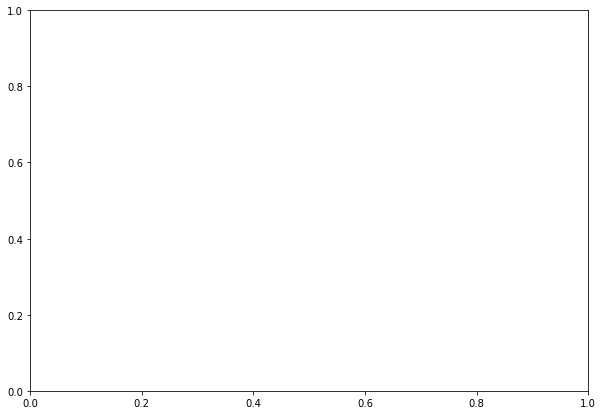

In [59]:
#Middle plot
bins = np.linspace( np.min(ellip_in_comp1) ,  np.max(ellip_in_comp1), n_of_splits + 1)

#bins = np.linspace(0, 1000, n+1)

indicies = np.digitize(ellip_in_comp1, bins)
print(indicies)


binned_data = [ellip_out_comp1[indicies == i] for i in range(1, n+1)]
bin_centres = 0.5 * (bins[:-1] + bins[1:])
bin_widths = 0.9 * (bins[1] - bins[0])

print(binned_data)

plt.boxplot(binned_data, positions = bin_centres, widths = bin_widths)

In [ ]:
#Bottom plot 

stats.binned_statistic(bins, binned_data)


In [ ]:
"""

np.max(ellip_in_comp1)
np.min(ellip_in_comp1)

n_of_splits = 10
splits = np.linspace( np.min(ellip_in_comp1) ,  np.max(ellip_in_comp1), n_of_splits)
print(splits)

part1 = (ellip_in_comp1[(splits[0] <= ellip_in_comp1) & ( ellip_in_comp1 <= splits[1])])
part2 = (ellip_in_comp1[(splits[1] <= ellip_in_comp1) & ( ellip_in_comp1 <= splits[2])])
part3 = (ellip_in_comp1[(splits[2] <= ellip_in_comp1) & ( ellip_in_comp1 <= splits[3])])
part4 = (ellip_in_comp1[(splits[3] <= ellip_in_comp1) & ( ellip_in_comp1 <= splits[4])])
part5 = (ellip_in_comp1[(splits[4] <= ellip_in_comp1) & ( ellip_in_comp1 <= splits[5])])
part6 = (ellip_in_comp1[(splits[5] <= ellip_in_comp1) & ( ellip_in_comp1 <= splits[6])])
part7 = (ellip_in_comp1[(splits[6] <= ellip_in_comp1) & ( ellip_in_comp1 <= splits[7])])
part8 = (ellip_in_comp1[(splits[7] <= ellip_in_comp1) & ( ellip_in_comp1 <= splits[8])])
part9 = (ellip_in_comp1[(splits[8] <= ellip_in_comp1) & ( ellip_in_comp1 <= splits[9])])

ellip_in_comp1_error = [part1, part2, part3, part4, part5, part6, part7, part8, part9]

#Work out the errors

ellip_in_comp1_error = ellip_in_comp1_error

print(ellip_in_comp1_error)

print(np.sum(ellip_in_comp1))
#print(np.sum(ellip_in_comp1_error))

"""


In [ ]:
#Need to split the arryas based on initial input value 

#Calculate the difference between its

In [ ]:

fig, axes = plt.subplots(1, 3, figsize = (17,5))

axes[0].set_title("Segment Flux of Component 1")
hex1 = axes[0].hexbin(flux_in_comp1, flux_out_comp1, gridsize=30, cmap='Blues', mincnt= n_mincnt, alpha=0.7)
axes[0].set_xlabel("Segment Flux of Component 1 [Input]")
axes[0].set_ylabel("Segment Flux of Component 1 [Output]")
fig.colorbar(hex1, ax=axes[0])

lims = [
    np.min([axes[0].get_xlim(), axes[0].get_ylim()]),  # min of both axes
    np.max([axes[0].get_xlim(), axes[0].get_ylim()]),  # max of both axes
]


# now plot both limits against eachother
axes[0].plot(lims, lims, 'k-', alpha=0.5, zorder=1)

axes[1].set_title("Segment Flux of Component 2")
hex2 = axes[1].hexbin(flux_in_comp2, flux_out_comp2, gridsize=30, cmap='Blues', mincnt= n_mincnt, alpha=0.7)
axes[1].set_xlabel("Segment Flux of Component 2 [Input]")
axes[1].set_ylabel("Segment Flux of Component 2 [Output]")
fig.colorbar(hex2, ax=axes[1])

lims = [
    np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
    np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
axes[1].plot(lims, lims, 'k-', alpha=0.5, zorder=1)

axes[2].set_title("Segment Flux of Blend")
hex3 = axes[2].hexbin(flux_in_blends, flux_out_blends, gridsize=30, cmap='Blues', mincnt= n_mincnt, alpha=0.7)
axes[2].set_xlabel("Segment Flux of Blend [Input]")
axes[2].set_ylabel("Segment Flux of Blend [Output]")
fig.colorbar(hex3, ax=axes[2])

lims = [
    np.min([axes[2].get_xlim(), axes[2].get_ylim()]),  # min of both axes
    np.max([axes[2].get_xlim(), axes[2].get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
axes[2].plot(lims, lims, 'k-', alpha=0.5, zorder=1)

fig.tight_layout()

plt.show()

In [ ]:


# Calculate accuracys 

ellip_comp1_accuracy = abs(ellip_out_comp1 / ellip_in_comp1) * 100
mean_ellip_comp1_accuracy = np.mean(ellip_comp1_accuracy)
median_ellip_comp1_accuracy = np.median(ellip_comp1_accuracy)

flux_comp1_accuracy = abs(flux_out_comp1 / flux_in_comp1) * 100
mean_flux_comp1_accuracy = np.mean(flux_comp1_accuracy)
median_flux_comp1_accuracy = np.median(flux_comp1_accuracy)

ellip_comp2_accuracy = abs(ellip_out_comp2 / ellip_in_comp2) * 100
mean_ellip_comp2_accuracy = np.mean(ellip_comp2_accuracy)
median_ellip_comp2_accuracy = np.median(ellip_comp2_accuracy)

flux_comp2_accuracy = abs(flux_out_comp2 / flux_in_comp2) * 100
mean_flux_comp2_accuracy = np.mean(flux_comp2_accuracy)
median_flux_comp2_accuracy = np.median(flux_comp2_accuracy)

flux_blend_accuracy = abs(flux_out_blends / flux_in_blends) * 100 
mean_flux_blend_accuracy = np.mean(flux_blend_accuracy)
median_flux_blend_accuracy = np.median(flux_blend_accuracy)


In [ ]:
print(f' Mean ellipticity accuracys: Component 1: {mean_ellip_comp1_accuracy :.4f}, Component 2: {mean_ellip_comp2_accuracy:.4f}')
print(f' Median ellipticity accuracys: Component 1: {median_ellip_comp1_accuracy:.4f}, Component 2: {median_ellip_comp2_accuracy:.4f} \n')

print(f' Mean flux accuracys: Component 1: {mean_flux_comp1_accuracy:.4f}, Component 2: {mean_flux_comp2_accuracy:.4f}, Blends: {mean_flux_blend_accuracy:.4f}')
print(f' Median flux accuracys: Component 1: {median_flux_comp1_accuracy:.4f}, Component 2: {median_flux_comp2_accuracy:.4f}, Blends: {median_flux_blend_accuracy:.4f}')